In [1]:
from scipy.optimize import fsolve
import pandas as pd
import numpy as np
import scipy
import matplotlib
from matplotlib import pyplot as plt
from scipy import integrate
from scipy.integrate import solve_ivp
from scipy.interpolate import RectBivariateSpline
from scipy.optimize import least_squares

In [2]:
k_B = 1.38e-16       #boltzmann constant [erg/K]
m_H = 1.67e-24       #hydrogen mass [g]
a_rad = 7.5657e-15   #radiation density const [erg cm^-3 K^-4]
G = 6.6743e-8        #gravitational constant [cm^3 g^-1 s^-2]
M = 1.2 * 1.98840987e33     #solar mass [g]
L_sun = 3.828e33     #solar luminosity [erg/s]
R_sun = 6.957e10      #radius of sun in cm
c = 2.99792458e10    #speed of light in cm
sigma = 5.67051e-5
gamma = 5/3
N_A = 6.022e23

X_H = 0.7
Y_He = 0.28
Z_M = 0.02
mu = 4 / (3 + 5*X_H)

In [3]:
file_name = 'Opacity.txt'
start_line = 242
table_row_length = 77
tables = {}

with open(file_name) as f:
    lines = f.readlines()

for i in range(126):
    table = {}
    title_items = lines[start_line + table_row_length * i - 1].split()

    table_name = f'Table {title_items[2]}'
    if i < 99:
        X = float(title_items[5].split('=')[1])
        Y = float(title_items[6].split('=')[1])
        Z = float(title_items[7].split('=')[1])
        dXc = float(title_items[8].split('=')[1])
        dXo = float(title_items[9].split('=')[1])
    else:
        X = float(title_items[4].split('=')[1])
        Y = float(title_items[5].split('=')[1])
        Z = float(title_items[6].split('=')[1])
        dXc = float(title_items[7].split('=')[1])
        dXo = float(title_items[8].split('=')[1])

    table['Composition'] = {'X': X, 'Y': Y, 'Z': Z, 'dXc': dXc, 'dXo': dXo}
    log_R_str = lines[start_line + table_row_length * i + 4 - 1].split()[1:]
    log_R = np.array([float(t) for t in log_R_str])
    table['log_R'] = log_R
    table_val = np.zeros((70, len(log_R)))
    log_T = []
    for j in range(70):
        line_to_process = lines[start_line + table_row_length * i + 5 + j].split()
        log_T.append(float(line_to_process[0]))
        val_str = lines[start_line + table_row_length * i + 5 + j].split()[1:]
        val = np.array([float(t) for t in val_str])
        table_val[j, 0:val.shape[0]] = val
    table['name'] = table_name
    table['log_T'] = np.array(log_T)
    table['val'] = table_val
    tables[table_name] = table

In [4]:
def get_opacity_tab(X, Y, Z):
    for i, table_name in enumerate(tables.keys()):
        if tables[table_name]['Composition']['X'] == X and tables[table_name]['Composition']['Y'] == Y and tables[table_name]['Composition']['Z'] == Z:
            table = tables[table_name]
            break
        if i == len(tables.keys()) - 1:
            raise ('Not found')
    return table

In [36]:
"""opacity_df = pd.read_csv("OPacity for X=0.7 Y=.28_fixed - Sheet1.csv")
logT_range = opacity_df.iloc[:, 0].values.astype(float)
logR_range = opacity_df.columns[1:].astype(str).str.strip().astype(float)
opacity_table = opacity_df.iloc[:, 1:].values.astype(float)
opacity_table[opacity_table == 9.999] = np.nan
interp_kappa = RectBivariateSpline(logT_range, logR_range, opacity_table)


def get_opacity(T, R, interp_kappa):
    logT = np.log10(np.maximum(T, 1e-10))
    logR = np.log10(np.maximum(R, 1e-20))
    opacity = interp_kappa.ev(logT, logR)
    return opacity


T_example = 4.4e4
R_example = 1e2
opacity_value = get_opacity(T_example, R_example, interp_kappa)
print(f"Opacity at T={T_example}, R={R_example}: {opacity_value}")"""

Opacity at T=44000.0, R=100.0: 5.352050711270443


In [5]:
tab = get_opacity_tab(X_H, Y_He, Z_M)
opacity = scipy.interpolate.RectBivariateSpline(tab['log_T'], tab['log_R'], tab['val'])

In [6]:
def energy_gen(density, temp, X, Z):
    T7 = temp/(1e7)
    T9 = temp/(1e9)

    #Weak screening factor
    f_ratio = (5.92e-3) * ((np.maximum(density, 1e-30) / np.maximum(T7**3, 1e-30))**0.5)
    screen_f = np.exp(np.clip(f_ratio, -100, 100))

    #PP chain epsilon
    g11 = 1+ (3.82*T9) + (1.51* (T9**2)) + (0.144 *(T9**3)) - (0.0114 *(T9**4))
    e_pp = (2.57e4) * g11* screen_f * density * (X**2) * (np.power(np.maximum(T9, 1e-10), -2/3)) * np.exp(np.clip(-3.381 / np.power(np.maximum(T9, 1e-10), 1/3), -100, 100))

    #CNO chain epsilon
    g14 = 1 - (2*T9) + (3.41*(T9**2)) - (2.43*(T9**3))
    e_cno = (8.24e25) * (0.7*Z) * X * g14* density * (np.power(np.maximum(T9, 1e-10), -2/3)) * np.exp(np.clip(-15.231 * np.power(np.maximum(T9, 1e-10), -1/3) - ((T9/0.8)**2), -100, 100))

    #Final epsilon
    e_tot = e_pp + e_cno

    return e_tot

In [7]:
def density(P,T,X):

    mu = 4 / (3 + (5*X))
    Prad = a_rad * (T**4)/3

    dens = (P - Prad) * (mu/ (T * k_B * N_A))
    return dens

In [8]:
def load1(Pc, Tc):
    #inner load
    m_core = 1e-10*M
    rho_1 = density(Pc, Tc, X_H)
    epsilon = energy_gen(rho_1,Tc,X_H,Z_M)

    r0 = (3*m_core/(4*np.pi*rho_1))**(1/3)
    l0 = epsilon * m_core
    Pc2 = Pc - (3 * G / 8 / np.pi) * (4 * np.pi * rho_1 / 3)**(4/3) * (m_core**(2/3))
    return [r0, l0, Pc2, Tc]



def load2(r, l):
    #outer load
    kappa = 0.32 #thomposon opacity
    P = (G * M / r**2) * (2 / 3) * (1 / kappa)
    T = (l / (4* np.pi * (r**2) * sigma))**(1/4)
    return [r,l,P,T]

In [9]:
nabla_ad = 0.4
def nabla_rad(m,P,l,T,kappa):
    nabla_rad = (3/(64*np.pi*sigma * G)) * (kappa*P*l)/(m * (T**4))
    return nabla_rad

In [10]:
def derivs(m,int_vals):

    r,l,P,T = int_vals
    rho = density(P,T,X_H)
    epsilon = energy_gen(rho,T,X_H,Z_M)

    logT = np.log10(np.maximum(T, 1e-20))
    if logT > 8.7:
        logT = 8.7
    if logT < 3.75:
        logT = 3.75

    R = rho / ((T*1e-6)**3)
    logR = np.log10(np.maximum(R, 1e-20))

    if logR > 1.0:
        logR = 1.0
    if logR < -8.0:
        logR = -8.0

    kappa = 10**(opacity(logT,logR)[0])

    nabla_ad = 0.4
    nabla_rad = (3/(64*np.pi*sigma*G)) * (P * l * kappa[0] / (m*(T**4)))
    nabla = min(nabla_ad, nabla_rad)


    dP_dm = -G * m / (4 * np.pi * r**4)
    dl_dm = epsilon
    dr_dm = 1/(4*np.pi*(r**2) * rho)
    dT_dm = -1*(G*m*T)/(4*np.pi*(r**4)*P) * nabla

    return [dr_dm, dl_dm, dP_dm, dT_dm]


In [11]:
def shootf(params):

    m_surf =  M
    m_mid = (M)/2
    m_core = 1e-10*( M) #better core mass lower limit

    center_vals = load1(params[2],params[3])
    surf_vals = load2(params[0], params[1])
    m_cent_steps = np.linspace(m_core, m_mid, 3000)
    m_surf_steps = np.linspace(m_surf, m_mid, 3000)
    sol_center = solve_ivp(derivs, [m_core,m_mid], center_vals, t_eval=m_cent_steps, method='RK45')
    sol_surf = solve_ivp(derivs, [m_surf,m_mid], surf_vals, t_eval = m_surf_steps, method='RK45')

    return sol_center.y, sol_surf.y, sol_center.t, sol_surf.t

In [17]:
Solar = np.array([R_sun, L_sun, 1.92e17, 1.571e7])
inital_adjustments = np.array([1.6,2.4,1.,1.05])
print(" (R, L, Pc, Tc):", Solar*inital_adjustments)

center, outter, center_m, outter_m = shootf(inital_adjustments * Solar)

 (R, L, Pc, Tc): [1.11312e+11 9.18720e+33 1.92000e+17 1.64955e+07]


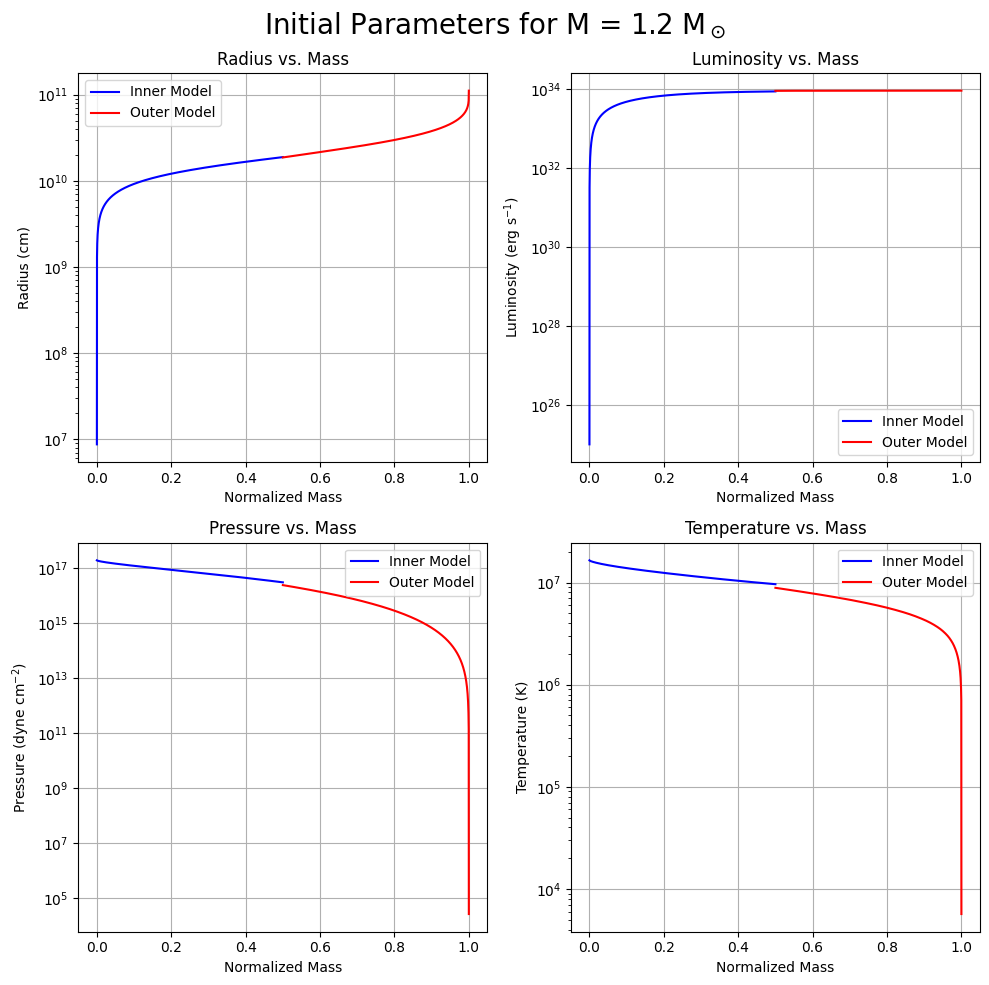

In [16]:
fig, ax = plt.subplots(2, 2, figsize = (10,10))

ax[0, 0].plot(center_m/M,center[0,:],label= 'Inner Model', c = 'b')
ax[0, 0].plot(outter_m/M,outter[0,:], label = 'Outer Model', c = 'r')
ax[0, 0].set_title('Radius vs. Mass')
ax[0, 0].set_yscale('log')
ax[0, 0].set_ylabel('Radius (cm)')
ax[0, 0].set_xlabel('Normalized Mass')
ax[0, 0].legend()
ax[0, 0].grid()


ax[0, 1].plot(center_m/M,center[1,:],label= 'Inner Model', c = 'b')
ax[0, 1].plot(outter_m/M,outter[1,:], label = 'Outer Model', c = 'r')
ax[0, 1].set_title('Luminosity vs. Mass')
ax[0, 1].set_yscale('log')
ax[0, 1].set_ylabel('Luminosity (erg s$^{-1}$)')
ax[0, 1].set_xlabel('Normalized Mass')
ax[0, 1].legend()
ax[0, 1].grid()


ax[1, 0].plot(center_m/M,center[2,:],label= 'Inner Model', c = 'b')
ax[1, 0].plot(outter_m/M,outter[2,:], label = 'Outer Model', c = 'r')
ax[1, 0].set_title('Pressure vs. Mass')
ax[1, 0].set_yscale('log')
ax[1, 0].set_ylabel('Pressure (dyne cm$^{-2}$)')
ax[1, 0].set_xlabel('Normalized Mass')
ax[1, 0].legend()
ax[1, 0].grid()


ax[1, 1].plot(center_m/M,center[3,:],label= 'Inner Model', c = 'b')
ax[1, 1].plot(outter_m/M,outter[3,:], label = 'Outer Model', c = 'r')
ax[1, 1].set_title('Temperature vs. Mass')
ax[1, 1].set_yscale('log')
ax[1, 1].set_ylabel('Temperature (K)')
ax[1, 1].set_xlabel('Normalized Mass')
ax[1, 1].legend()
ax[1, 1].grid()


fig.suptitle('Initial Parameters for M = 1.2 M$_\odot$', fontsize=20)
fig.tight_layout()

In [14]:
def mid_pt_diff(params_scaled, guess):
    scaled_variables = params_scaled * Solar
    inner, outter, inner_m, outter_m = shootf(scaled_variables)

    diff = (inner[:,-1] - outter[:,-1]) / (inner[:,0]- outter[:,0])

    mid_points = np.sum(diff**2)
    return (mid_points)

In [123]:
#least squares metho of optimization instead of the root function, root had high >50% difference to MESA

Solar = [R_sun, L_sun, 1.92e17, 1.5e7]

params_scaled_2=[1.4,2.,1.,1.1]

boundaries = ([0.1,0.1,0.1,0.1], [3,4,2,2])

result = least_squares(mid_pt_diff,params_scaled_2, bounds=boundaries, args=([Solar]), method='trf', loss='soft_l1', verbose=2, max_nfev=500 )
optimized= result.x

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.5896e-04                                    8.74e-02    
       1              2         3.4429e-05      4.25e-04       9.78e-03       1.01e-02    
       2              3         1.7675e-05      1.68e-05       6.56e-03       3.49e-03    
       3              5         1.0968e-05      6.71e-06       2.10e-03       1.87e-03    
       4              6         5.3215e-06      5.65e-06       4.23e-03       1.60e-03    
       5              7         1.1771e-06      4.14e-06       1.03e-02       6.48e-04    
       6              9         7.5831e-07      4.19e-07       5.27e-03       4.72e-04    
       7             11         4.3501e-07      3.23e-07       1.09e-03       1.46e-04    
       8             12         3.0003e-07      1.35e-07       1.09e-03       1.14e-04    
       9             13         1.5495e-07      1.45e-07       2.11e-03       1.10e-04    

In [124]:
optimized

array([1.42447772, 2.01321688, 0.98597096, 1.07444172])

In [125]:
final_params = optimized*Solar
final_params

array([9.91009151e+10, 7.70659421e+33, 1.89306425e+17, 1.61166258e+07])

In [126]:
centter2, outter2, centter_mass, outtter_mass = shootf(optimized*Solar)

In [127]:
reversed_out2 = outter2[:,::-1]
np.shape(reversed_out2[0,:])

(3000,)

Final physical parameters (R, L, Pc, Tc): [9.91009151e+10 7.70659421e+33 1.89306425e+17 1.61166258e+07]


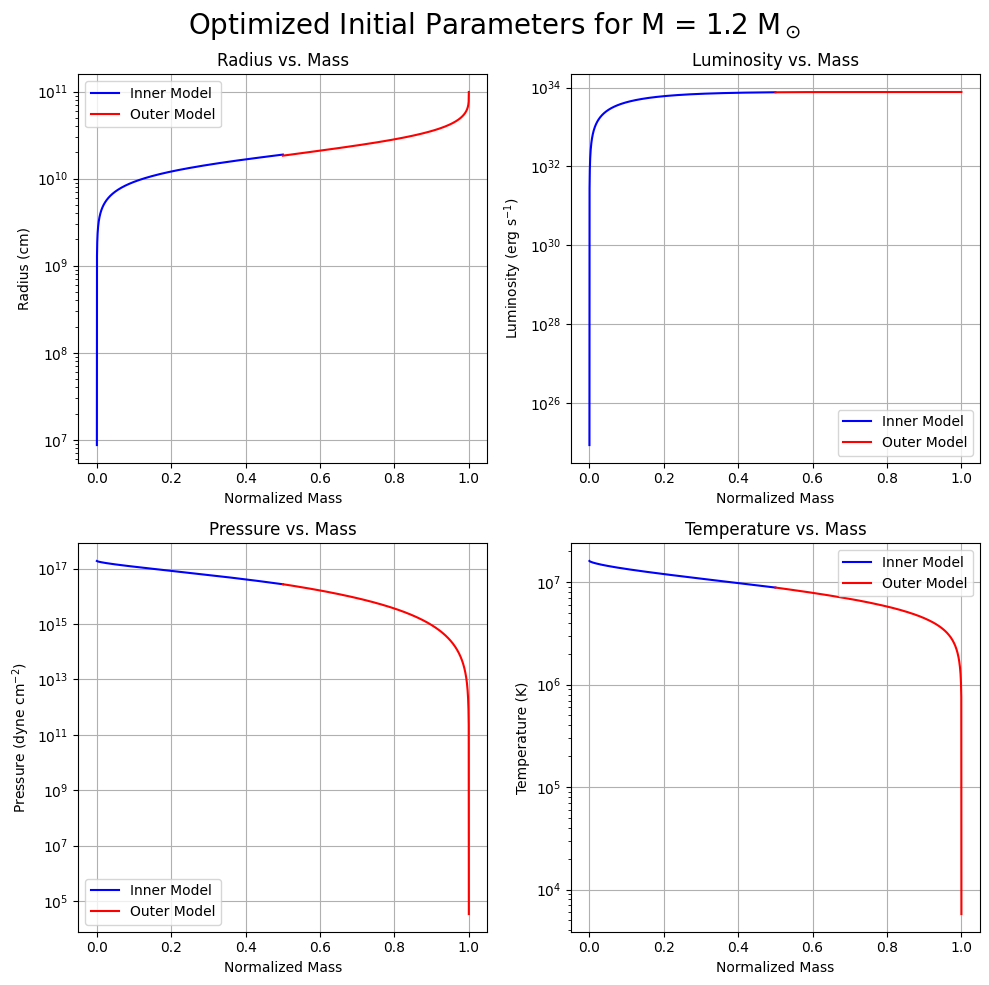

In [128]:
final_params = optimized * Solar
print("Final physical parameters (R, L, Pc, Tc):", final_params)

center2, outter2, center_m2, outter_m2 = shootf(final_params)


fig, ax = plt.subplots(2, 2, figsize=(10, 10))
Mass = M

# Radius vs Mass
ax[0, 0].plot(center_m2/Mass, center2[0, :], label='Inner Model', c = 'b')
ax[0, 0].plot(outter_m2/Mass, outter2[0, :], label='Outer Model', c = 'r')
ax[0, 0].set_title('Radius vs. Mass')
ax[0, 0].set_yscale('log')
ax[0, 0].set_ylabel('Radius (cm)')
ax[0, 0].set_xlabel('Normalized Mass')
ax[0, 0].legend()
ax[0, 0].grid()

# Luminosity vs Mass
ax[0, 1].plot(center_m2/Mass, center2[1, :], label='Inner Model', c = 'b')
ax[0, 1].plot(outter_m2/Mass, outter2[1, :], label='Outer Model', c = 'r')
ax[0, 1].set_title('Luminosity vs. Mass')
ax[0, 1].set_yscale('log')
ax[0, 1].set_ylabel('Luminosity (erg s$^{-1}$)')
ax[0, 1].set_xlabel('Normalized Mass')
ax[0, 1].legend()
ax[0, 1].grid()

# Pressure vs Mass
ax[1, 0].plot(center_m2/Mass, center2[2, :], label='Inner Model', c = 'b')
ax[1, 0].plot(outter_m2/Mass, outter2[2, :], label='Outer Model', c = 'r')
ax[1, 0].set_title('Pressure vs. Mass')
ax[1, 0].set_yscale('log')
ax[1, 0].set_ylabel('Pressure (dyne cm$^{-2}$)')
ax[1, 0].set_xlabel('Normalized Mass')
ax[1, 0].legend()
ax[1, 0].grid()

# Temperature vs Mass
ax[1, 1].plot(center_m2/Mass, center2[3, :], label='Inner Model', c = 'b')
ax[1, 1].plot(outter_m2/Mass, outter2[3, :], label='Outer Model', c = 'r')
ax[1, 1].set_title('Temperature vs. Mass')
ax[1, 1].set_yscale('log')
ax[1, 1].set_ylabel('Temperature (K)')
ax[1, 1].set_xlabel('Normalized Mass')
ax[1, 1].legend()
ax[1, 1].grid()

# Overall figure formatting
fig.suptitle('Optimized Initial Parameters for M = 1.2 M$_\\odot$', fontsize=20)
fig.tight_layout()
fig.savefig('Optimized_plots.png')
plt.show()

In [129]:
df = pd.read_csv('history.data', sep="\s+", header=4)
df.columns

Index(['model_number', 'num_zones', 'star_age', 'log_dt', 'star_mass',
       'log_xmstar', 'log_abs_mdot', 'mass_conv_core', 'conv_mx1_top',
       'conv_mx1_bot', 'conv_mx2_top', 'conv_mx2_bot', 'mx1_top', 'mx1_bot',
       'mx2_top', 'mx2_bot', 'log_LH', 'log_LHe', 'log_LZ', 'log_Lnuc', 'pp',
       'cno', 'tri_alpha', 'epsnuc_M_1', 'epsnuc_M_2', 'epsnuc_M_3',
       'epsnuc_M_4', 'epsnuc_M_5', 'epsnuc_M_6', 'epsnuc_M_7', 'epsnuc_M_8',
       'he_core_mass', 'co_core_mass', 'one_core_mass', 'fe_core_mass',
       'neutron_rich_core_mass', 'log_Teff', 'log_L', 'log_R', 'log_g',
       'v_div_csound_surf', 'log_cntr_P', 'log_cntr_Rho', 'log_cntr_T',
       'center_mu', 'center_ye', 'center_abar', 'center_h1', 'center_he4',
       'center_c12', 'center_o16', 'surface_c12', 'surface_o16',
       'total_mass_h1', 'total_mass_he4', 'num_retries', 'num_iters'],
      dtype='object')

In [130]:
logP = 10** np.array(df['log_cntr_P'].tail(1))
logT = 10 **np.array (df['log_cntr_T'].tail(1))
logR =10 **np.array( df['log_R'].tail(1))
logL =10** np.array( df['log_L'].tail(1))

In [137]:
mesa_final_params = np.array([logR[0]*R_sun, logL[0]*L_sun, logP[0], logT[0]])
mesa_final_params

array([7.98626536e+10, 6.58472601e+33, 1.77187935e+17, 1.55959889e+07])

In [138]:
perc_diff = 100 *(final_params - mesa_final_params)/ mesa_final_params
print(f'Percent difference between MESA stellar paramenters and optimized model for R, L, Pc, and Tc are {perc_diff[0]:.2f}%, {perc_diff[1]:.2f}%, {perc_diff[2]:.2f}%, {perc_diff[3]:.2f}%')

Percent difference between MESA stellar paramenters and optimized model for R, L, Pc, and Tc are 24.09%, 17.04%, 6.84%, 3.34%


In [139]:
df = pd.read_csv('profile5.data', sep="\s+", header=4)
df.columns

Index(['zone', 'mass', 'logR', 'logT', 'logRho', 'logP', 'x_mass_fraction_H',
       'y_mass_fraction_He', 'z_mass_fraction_metals', 'pp', 'cno',
       'tri_alpha'],
      dtype='object')

In [140]:
m_mesa = df['mass']
r_mesa = np.power(10, df['logR'])
t_mesa = np.power(10, df['logT'])
p_mesa = np.power(10, df['logP'])
rho_mesa = np.power(10, df['logRho'])


In [141]:
rho_profile1 = density(center2[2,:],center2[3,:],X_H)
rho_profile2 = density(outter2[2,:],outter2[3,:],X_H)

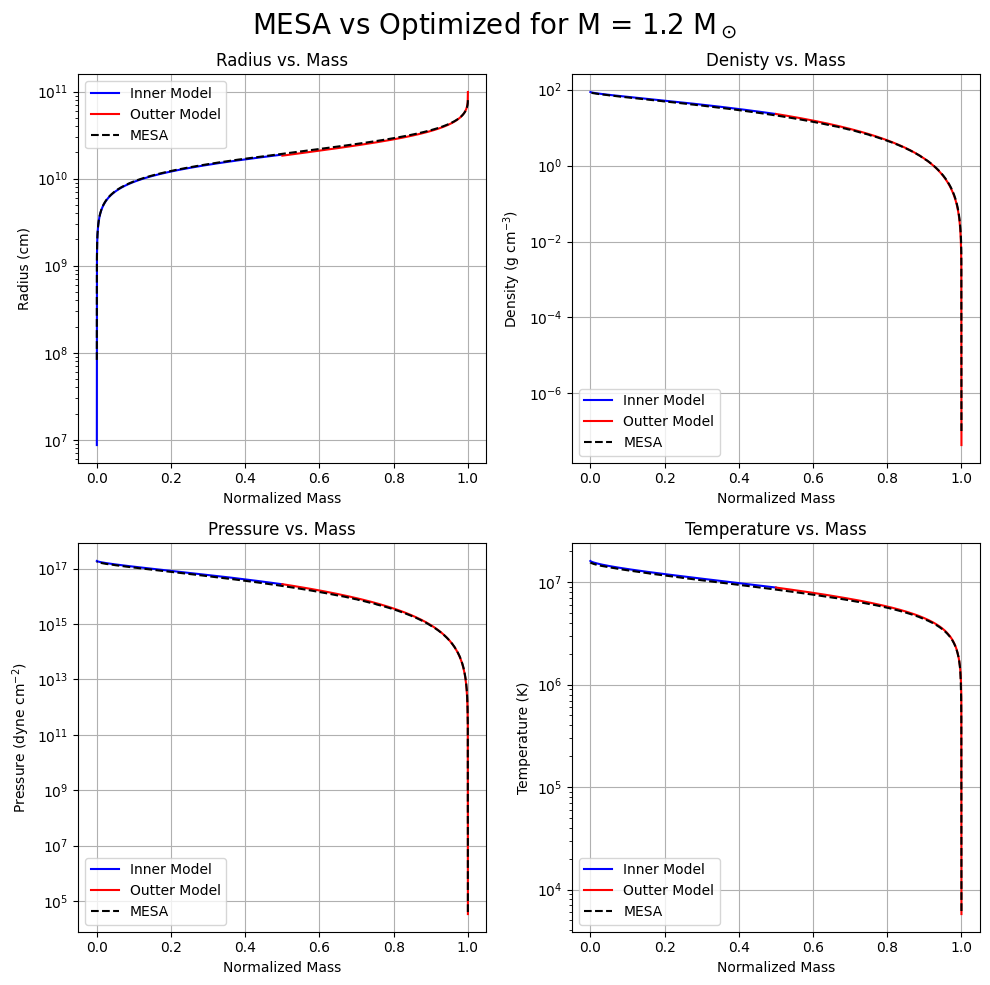

In [142]:
fig, ax = plt.subplots(2, 2, figsize = (10,10))

ax[0, 0].plot(center_m2/Mass,center2[0,:],label= 'Inner Model', c = 'b')
ax[0, 0].plot(outter_m2/Mass,outter2[0,:], label = 'Outter Model', c = 'r')
ax[0, 0].plot(m_mesa/1.2,r_mesa*R_sun, label = 'MESA',linestyle='--', c = 'k')
ax[0, 0].set_title('Radius vs. Mass')
ax[0, 0].set_yscale('log')
ax[0, 0].set_ylabel('Radius (cm)')
ax[0, 0].set_xlabel('Normalized Mass')
ax[0, 0].legend()
ax[0, 0].grid()

ax[0, 1].plot(center_m2/Mass,rho_profile1,label= 'Inner Model', c = 'b')
ax[0, 1].plot(outter_m2/Mass,rho_profile2, label = 'Outter Model', c = 'r')
ax[0, 1].plot(m_mesa/1.2,rho_mesa, label = 'MESA',linestyle='--', c = 'k')
ax[0, 1].set_title('Denisty vs. Mass')
ax[0, 1].set_yscale('log')
ax[0, 1].set_ylabel('Density (g cm$^{-3}$)')
ax[0, 1].set_xlabel('Normalized Mass')
ax[0, 1].legend()
ax[0, 1].grid()

ax[1, 0].plot(center_m2/Mass,center2[2,:],label= 'Inner Model', c = 'b')
ax[1, 0].plot(outter_m2/Mass,outter2[2,:], label = 'Outter Model', c = 'r')
ax[1, 0].plot(m_mesa/1.2,p_mesa, label = 'MESA',linestyle='--', c = 'k')
ax[1, 0].set_title('Pressure vs. Mass')
ax[1, 0].set_yscale('log')
ax[1, 0].set_ylabel('Pressure (dyne cm$^{-2}$)')
ax[1, 0].set_xlabel('Normalized Mass')
ax[1, 0].legend()
ax[1, 0].grid()

ax[1, 1].plot(center_m2/Mass,center2[3,:],label= 'Inner Model', c = 'b')
ax[1, 1].plot(outter_m2/Mass,outter2[3,:], label = 'Outter Model', c = 'r')
ax[1, 1].plot(m_mesa/1.2,t_mesa, label = 'MESA', linestyle='--', c = 'k')
ax[1, 1].set_title('Temperature vs. Mass')
ax[1, 1].set_yscale('log')
ax[1, 1].set_ylabel('Temperature (K)')
ax[1, 1].set_xlabel('Normalized Mass')
ax[1, 1].legend()
ax[1, 1].grid()


fig.suptitle('MESA vs Optimized for M = 1.2 M$_\odot$', fontsize=20)
fig.tight_layout()
fig.savefig('Mesa_plots.png')

In [143]:
def gen_data_table(params):
    center2, outter2, center_mass, outter_mass = shootf(params)

    reversed_out2 = outter2[:,::-1]
    reversed_out_mass = outter_mass[::-1]

    rval = np.concatenate((center2[0,:],reversed_out2[0,:]))
    lval = np.concatenate((center2[1,:],reversed_out2[1,:]))
    Pval = np.concatenate((center2[2,:],reversed_out2[2,:]))
    Tval = np.concatenate((center2[3,:],reversed_out2[3,:]))
    mval = np.concatenate((center_mass,reversed_out_mass))

    rho_val = density(Pval,Tval,X_H)
    epsilon_val = energy_gen(rho_val,Tval,X_H,Z_M)

    logT = np.log10(Tval)

    R = rho_val / ((Tval*1e-6)**3)
    logR = np.log10(R)

    nabla_val=[]
    conv_status=[]
    for i in range(len(logT)):

        kappa_val = 10**(opacity(logT[i],logR[i])[0])

        nabla_ad = 0.4
        nabla_rad = (3/(64*np.pi*sigma*G)) * (kappa_val[0]*Pval[i]*lval[i])/(mval[i] * (Tval[i]**4))
        #nabla_rad = nabla_rad[0]
        nabla_val.append(min(nabla_ad, nabla_rad))

        if nabla_ad > nabla_rad:
            conv_status.append(0)
        else:
            conv_status.append(1)


    return [mval, rval, lval, Pval, Tval, rho_val, epsilon_val, nabla_val, conv_status]

In [144]:
data = gen_data_table(final_params)
np.shape(data)

(9, 6000)

In [145]:
headers = ['Mass', 'Radius', 'Luminosity', 'Pressure', 'Temperature', 'Density', 'epsilon', 'nabla', 'radiative=1, convetice=0']
df = pd.DataFrame(np.transpose(data), columns = headers)

In [146]:
df

,Mass,Radius,Luminosity,Pressure,Temperature,Density,epsilon,nabla,"radiative=1, convetice=0"
0,2.386092e+23,8.686744e+06,8.518294e+24,1.893063e+17,1.611663e+07,8.690151e+01,3.569976e+01,0.400000,1.0
1,3.978148e+29,1.029597e+09,1.403569e+31,1.881948e+17,1.607871e+07,8.659527e+01,3.500783e+01,0.400000,1.0
2,7.956294e+29,1.298030e+09,2.788009e+31,1.875415e+17,1.605635e+07,8.641495e+01,3.460869e+01,0.400000,1.0
3,1.193444e+30,1.486829e+09,4.158061e+31,1.869922e+17,1.603753e+07,8.626314e+01,3.427734e+01,0.400000,1.0
4,1.591259e+30,1.637950e+09,5.515802e+31,1.864977e+17,1.602055e+07,8.612631e+01,3.398231e+01,0.400000,1.0
...,...,...,...,...,...,...,...,...,...
5995,2.384501e+33,7.510603e+10,7.706594e+33,5.109694e+11,8.995462e+05,4.192687e-03,3.548386e-12,0.209444,0.0
5996,2.384898e+33,7.661075e+10,7.706594e+33,3.585130e+11,8.357245e+05,3.165743e-03,1.178387e-12,0.207057,0.0
5997,2.385296e+33,7.861664e+10,7.706594e+33,2.191574e+11,7.555741e+05,2.139804e-03,2.495695e-13,0.206070,0.0
5998,2.385694e+33,8.174925e+10,7.706594e+33,9.615761e+10,6.374054e+05,1.112271e-03,1.664709e-14,0.208421,0.0


In [147]:
df.to_csv('Final_output_table.csv')